# Analiza zbioru danych związanych z katastrofą Titanica
### Na podsawie poniższej analizy chciałbym zobaczyć i określić czynniki związanych z przeżywalonością pasażerów statku

## 1. Określenie Problemu
### Zrozumienie wpływu czynników decydujących na przezprzywalności pasażerów podczas katastrofy Titanica.
* Czy istnieje różnica w szansach przeżycia między mężczyznami a kobietami?
* Czy klasa biletu związna była z większą szansą przeżycia?
* Czy wiek pasażera miał wpływ na jego szanse przeżycia?
* Czy inne czynniki, takie jak stan cywilny, wielkość rodziny, bądz miejsce na statku miały istone znaczenie.

## 2. Wstępne zapoznanie się z danymi 
### Załadowanie podstawowych bibliotek, oraz bazy danych.

In [1]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire', 4)

%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OneHotEncoder

# Baza danych
Titanic = pd.read_csv("Titanic_Database.csv") 

In [2]:
Titanic.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [3]:
print(Titanic.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Zbiór danych zawiera następujące informacje:

*  PassengerId: Unikatowy identyfikator pasażera
*  Survived: Czy pasażer przeżył (1) czy zginął (0)
*  Pclass: Klasa biletu (1=pierwsza, 2=druga, 3=trzecia)
*  Name: Imię i nazwisko pasażera, staus cywilny
*  Sex: Płeć pasażera (male, female)
*  Age: Wiek pasażera
*  SibSp: Liczba rodzeństwa i/lub małżonka na pokładzie
*  Parch: Liczba rodziców i/lub dzieci na pokładzie
*  Ticket: Numer biletu
*  Fare: Cena biletu
*  Cabin: Numer kabiny
*  Embarked: Port zaokrętowania (C = Cherbourg, Q = Queenstown, S = Southampton)

In [4]:
Titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3. Czyszczenie i przygotowanie danych

In [5]:
#Sprawdzenie wartości zerowych
print(pd.isnull(Titanic).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Przygotowanie danych

In [6]:
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


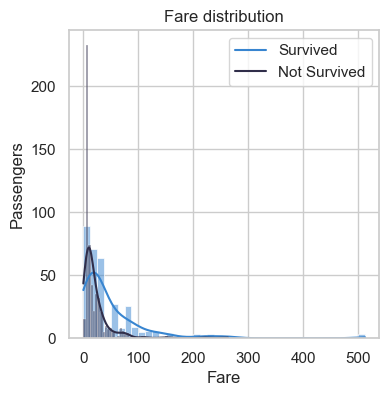

In [7]:
fig, axes = plt.subplots(figsize=(4,4))
axes.set_ylabel('Passengers')
axes.set_title('Fare distribution')
sns.histplot(Titanic[Titanic['Survived']==1]['Fare'],kde=True)
sns.histplot(Titanic[Titanic['Survived']==0]['Fare'],kde=True)
axes.legend(['Survived','Not Survived'])

In [8]:
## Powyższa grafika wskazuje dlaczego decyduję się nie dyskretyzować/encodować danych. Wykorzsytam dane w sposób ciągły. Dlasze rozważenia nad podzielenm tego zostną rowważone wyłącznie gddy prześlę to dla ML Kaggle.
# Mapping Fare
#Titanic.loc[Titanic['Fare'] <=  7.895800,                                 'Fare'] = 0
#Titanic.loc[(Titanic['Fare'] >  7.895800) & (Titanic['Fare'] <= 14.4542), 'Fare'] = 1
#Titanic.loc[(Titanic['Fare'] > 14.4542)   & (Titanic['Fare'] <=  31.5),   'Fare'] = 2
#Titanic.loc[Titanic['Fare'] >  31.5,                                      'Fare'] = 3
#Titanic['Fare'].value_counts()

####  Określenie stanu cywilnego danego paseżera.

In [9]:
def get_title(name):
    # Wyodrębnij prefix z imienia
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Rare'
    elif title in ['Mlle']:
        return 'Miss'
    elif title in ['Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    else:
        return title
Titanic['Title'] = Titanic['Name'].apply(get_title)
title_percentages = Titanic['Title'].value_counts(normalize=True)
print(title_percentages)

Title
Mr              0.580247
Miss            0.207632
Mrs             0.141414
Master          0.044893
Rare            0.024691
the Countess    0.001122
Name: proportion, dtype: float64


### OneHotencodowanie danych categorycznych

In [10]:
# Import OneHotEncoder from scikit-learn
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)  # Set sparse_output=False for dense output
categorical_features = ['Sex', 'Embarked', 'Title']
encoded_features = ohe.fit_transform(Titanic[categorical_features])

# Add encoded columns to DataFrame
for i, col in enumerate(categorical_features):
    Titanic[col + "_Enc"] = encoded_features[:, i]

# Create mapping dictionary (optional)
ohe_mapping = {}
for i, col in enumerate(categorical_features):
    categories = ohe.categories_[i]
    encoded_values = range(len(categories))
    mapping = dict(zip(categories, encoded_values))
    ohe_mapping[col] = mapping

# Print mapping for each column (if using ohe_mapping)
for col in categorical_features:
    print(f"Kolumna: {col}")
    if 'ohe_mapping' in locals():  # Check if ohe_mapping was created
        mapping = ohe_mapping[col]
        for category, encoded_value in mapping.items():
            print(f"  {category}: {encoded_value}")
    else:
        print(f"  Mapping not created. Use 'ohe_mapping' for category-to-encoding lookup.")
    print()

Kolumna: Sex
  female: 0
  male: 1

Kolumna: Embarked
  C: 0
  Q: 1
  S: 2
  nan: 3

Kolumna: Title
  Master: 0
  Miss: 1
  Mr: 2
  Mrs: 3
  Rare: 4
  the Countess: 5



In [11]:
### Sumareyczne wyniki/punkt odniesnia dla danych kattegorycznych, kótóre zostały zencodowane. 

## Wybór danych
#### Ocena kategorii, które mogą zostać bezwzględnie usunięte nie planuję ich brać w dalszej lub zostały zencodowane. Oczywiście pełne usprawidliwnie powinno pojawić się tutaj tłumacząc dlaczego obecność danej kategorii nie wnośi niczego co mógłbym wykorzystać dalej do modelu, jednak nie mieszam kroków. 

In [12]:
# Usuń oryginalne kolumny
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
Titanic.drop(columns=categorical_features, inplace=True)
Titanic.tail()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Enc,Embarked_Enc,Title_Enc
886,0,2,27.0,0,0,13.00,0.0,1.0,0.0
887,1,1,19.0,0,0,30.00,1.0,0.0,0.0
888,0,3,NaN,1,2,23.45,1.0,0.0,0.0
889,1,1,26.0,0,0,30.00,0.0,1.0,1.0
890,0,3,32.0,0,0,7.75,0.0,1.0,0.0


In [13]:
Titanic[['Age', 'Fare']] = Titanic[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Survived' ,'Pclass', 'SibSp', 'Parch', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
Titanic[columns_to_convert] = Titanic[columns_to_convert].astype(np.int16)
Titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int16  
 1   Pclass        891 non-null    int16  
 2   Age           714 non-null    float32
 3   SibSp         891 non-null    int16  
 4   Parch         891 non-null    int16  
 5   Fare          891 non-null    float32
 6   Sex_Enc       891 non-null    int16  
 7   Embarked_Enc  891 non-null    int16  
 8   Title_Enc     891 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 19.3 KB


In [14]:
Titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Enc,Embarked_Enc,Title_Enc
0,0,3,22.0,1,0,7.250000,0,1,0
1,1,1,38.0,1,0,71.283302,1,0,1
2,1,3,26.0,0,0,7.925000,1,0,0
3,1,1,35.0,1,0,53.099998,1,0,0
4,0,3,35.0,0,0,8.050000,0,1,0
...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.000000,0,1,0
887,1,1,19.0,0,0,30.000000,1,0,0
888,0,3,NaN,1,2,23.450001,1,0,0
889,1,1,26.0,0,0,30.000000,0,1,1


## 4. Wizualizacja i ekspoloracja wzorców

In [15]:
Titanic.groupby('Sex_Enc').mean().round(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_Enc,Title_Enc
Sex_Enc,,,,,,,,
0,0.19,2.39,30.73,0.43,0.24,25.52,1.0,0.16
1,0.74,2.16,27.92,0.69,0.65,44.48,0.0,0.23


In [16]:
Titanic.groupby('Survived').mean().round(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_Enc,Embarked_Enc,Title_Enc
Survived,,,,,,,,
0,2.53,30.629999,0.55,0.33,22.120001,0.15,0.85,0.14
1,1.95,28.340000,0.47,0.46,48.400002,0.68,0.32,0.27


Text(0.5, 1.05, 'Pearson Correlation of Features')

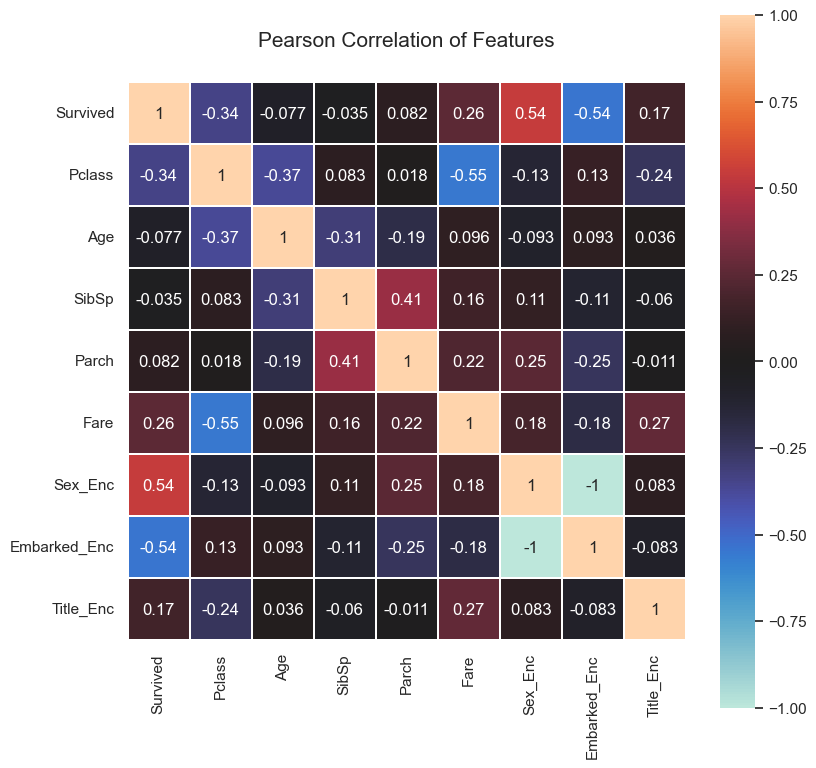

In [17]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire')
ax.set_title('Pearson Correlation of Features', y=1.05, size=15)

###  Roskład  wieku  pasażerów

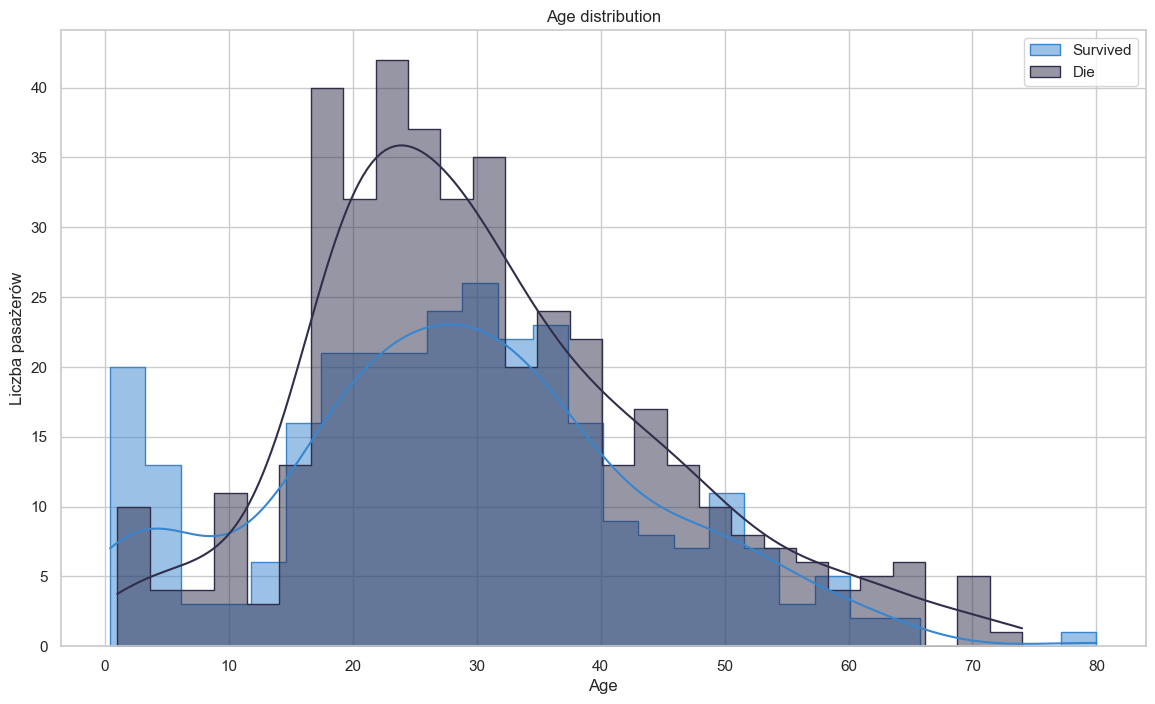

In [33]:
fig, axes = plt.subplots(figsize=(14,8))
axes.set_ylabel('Liczba pasażerów')
axes.set_xlabel('Age')
axes.set_title('Age distribution')
sns.histplot(Titanic[Titanic['Survived']==1]['Age'],kde=True, bins=28, element='step', label='Survived')
sns.histplot(Titanic[Titanic['Survived']==0]['Age'],kde=True, bins=28, element='step', label='Die')
axes.legend()

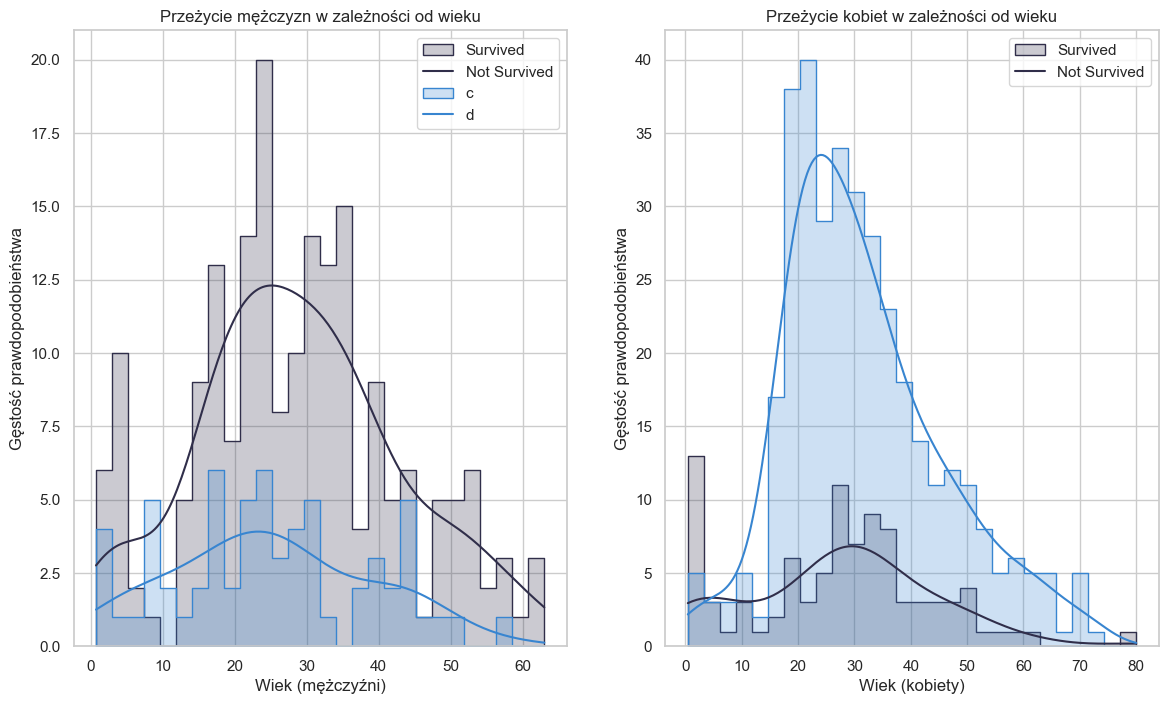

In [37]:
# dwa wykresy
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

# Mężczyźni
sns.histplot(Titanic[Titanic['Sex_Enc']==1], x='Age', hue='Survived',kde=True,  element='step', bins=28,
             common_norm=False, ax=ax1)
ax1.set_xlabel('Wiek (mężczyźni)')
ax1.set_ylabel('Gęstość prawdopodobieństwa')
ax1.set_title('Przeżycie mężczyzn w zależności od wieku')

# Kobiety
sns.histplot(Titanic[Titanic['Sex_Enc']==0], x='Age', hue='Survived', kde=True,  element='step', bins=28,
             common_norm=False, ax=ax2)
ax2.set_xlabel('Wiek (kobiety)')
ax2.set_ylabel('Gęstość prawdopodobieństwa')
ax2.set_title('Przeżycie kobiet w zależności od wieku')
ax2.legend(['Survived','Not Survived'])


<Axes: xlabel='Sex_Enc', ylabel='Age'>

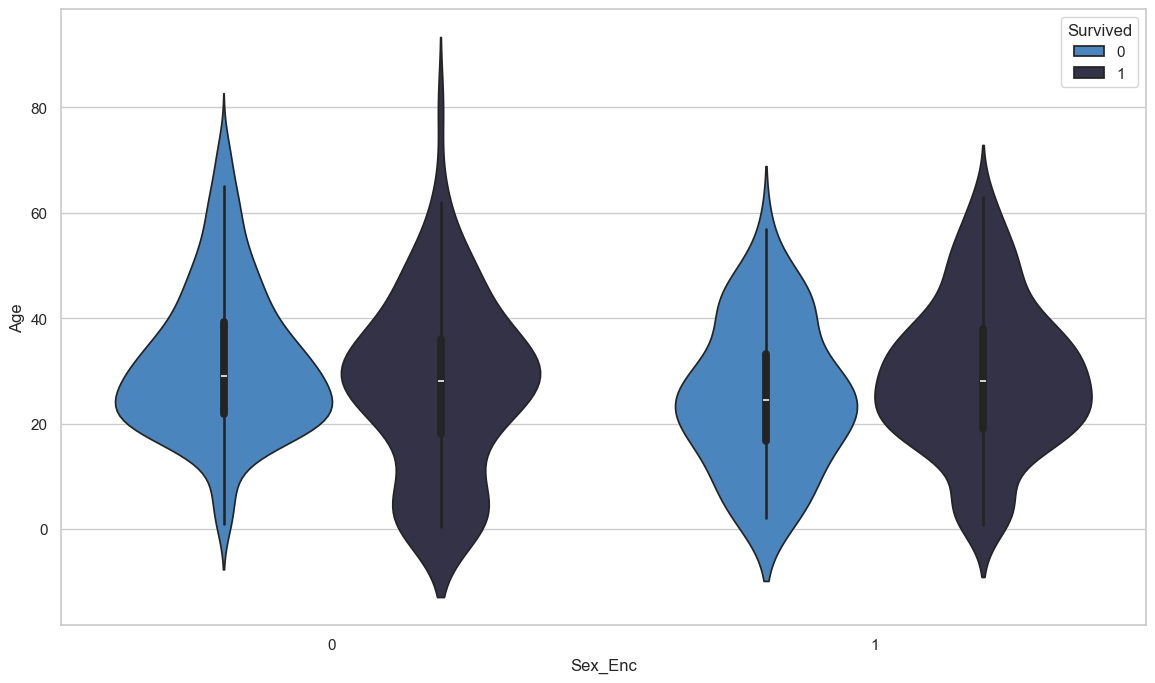

In [42]:
plt.subplots(figsize=(14,8))
sns.violinplot(data=Titanic, x="Sex_Enc", y="Age", hue="Survived")



<Axes: xlabel='Pclass', ylabel='Age'>

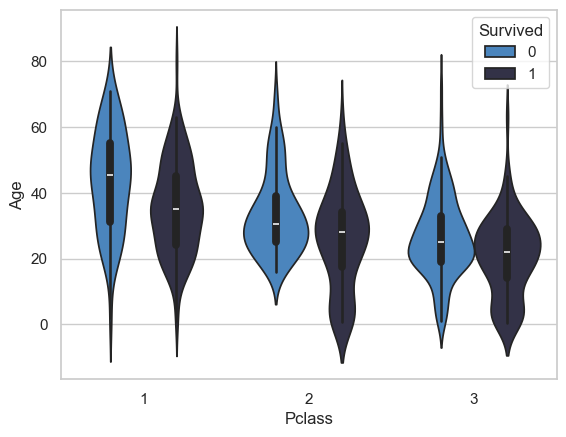

In [44]:
sns.violinplot(data=Titanic, x="Pclass", y="Age", hue="Survived")
